<div style="text-align: right"> York University - ML1030 - Julia Mitroi </div>

# Sentiment Analysis for Movie Reviews

## Text Pre-processing/Normalization + Keras Sequential Model

### Installing libraries and packages

In [1]:
import os
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import re

import seaborn as sns

import random

import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout , Embedding, Conv1D , MaxPooling1D , Input, Reshape , Masking , TimeDistributed
from keras.layers import Concatenate, BatchNormalization, Bidirectional, Activation, GlobalMaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from keras.callbacks import History, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score
from sklearn.metrics import recall_score , confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

C:\Users\julia.mitroi\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
train_reviews = pd.read_csv("train.tsv", sep="\t")

In [3]:
test_reviews = pd.read_csv("test.tsv", sep="\t")

### Data Cleaning

In [4]:
# Make reviews text lowercase
train_reviews['Phrase'] = train_reviews['Phrase'].str.lower()
test_reviews['Phrase'] = test_reviews['Phrase'].str.lower()

In [5]:
train_reviews['Phrase'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [6]:
# Leaving only letters from a-z and digits
train_reviews['Phrase'] = train_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_reviews['Phrase'] = test_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [7]:
# Removing HTML content
train_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in train_reviews['Phrase']]
test_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in test_reviews['Phrase']]

### Treebank Tokenization

In [8]:
# Using the Penn U.'s' Treebank Word Tokenazer from ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html
# Through tokenization, each sentence is converterd to a sequence of tokens. 

treebank_tokenizer = TreebankWordTokenizer()

def tokenize(t):
    return ' '.join(treebank_tokenizer.tokenize(t))

sentences = train_reviews.Phrase.apply(tokenize)

### Lemmatization

In [9]:
# NLTK's WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(l):
    return ' '.join([lemmatizer.lemmatize(s) for s in l.split(' ')])    
    
sentences = sentences.apply(lemmatize)

### Stemming

In [10]:
# NLTK's Stemmer

stemmer = PorterStemmer()

def stem(s):
    return ' '.join([stemmer.stem(w) for w in s.split(' ')])

sentences = sentences.apply(stem)

In [11]:
sentences.head()

0    a seri of escapad demonstr the adag that what ...
1    a seri of escapad demonstr the adag that what ...
2                                               a seri
3                                                    a
4                                                 seri
Name: Phrase, dtype: object

### Keras Pre-processing

In [12]:
# Preliminary to modeling, I will use Keras text preprocessing functions to further pre-process the sentences in the 
# train set, namely to transform the text into sequences of tokens, and pad those sequences to have the same length.

tokenizer = Tokenizer()
# fit_on_texts function creates vocabulary index based on word frequency in sentences
tokenizer.fit_on_texts(sentences)

# texts_to_sequences transforms each text in the sentences set to a sequence of integers
X = tokenizer.texts_to_sequences(sentences)

from keras.preprocessing.sequence import pad_sequences
# pad_sequences performs sequences padding
X = pad_sequences(X)

# Constructing the target
Y = pd.get_dummies(train_reviews.Sentiment).values

In [19]:
# Vocabulary Size.
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: ", vocab_size)
print("X's shape : " , X.shape)
print("Y's shape : " , X.shape)

Vocabulary size:  11965
X's shape :  (156060, 48)
Y's shape :  (156060, 48)


## Modeling

### Baseline Model Accuracy

In [20]:
from sklearn.metrics import accuracy_score
# Before building a deep learning model, I am computing the baseline accuracy classification score
print('Baseline Accuracy Classification Score: ', accuracy_score(train_reviews.Sentiment.values[-1000:] , [3 for _ in range(1000)]))

Baseline Accuracy Classification Score:  0.213


### LSTM + Dense NN Architecture

In [21]:
# Model Definition, using Keras Sequential Model:
# LSTM Network followed by a regular densely-connected (fully connected) Neural Network layer, using an embedding Layer
# Architecture and model parameters similar to the one suggested at: 
# https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

def model(X , Y , embed_dim , vocab_size,
          lstm_layers = [] , lstm_dropout = [],
          dense_layers = [] , dense_dropout = [] ,
          ntest_sers = 400 , epochs = 10 , batch_size = 32 , lr = 0.001):
        
    length  = X.shape[0] 
    target_shape = Y.shape[1]
    
    # Validation rate to pass to the Sequential Model:
    val_rate = ntest_sers/length
    
    # Model:
    
    history = History()
    checkpoint = ModelCheckpoint('model' , save_best_only=True)
    
    # Initializing model by setting up the layers
    
    # As first layer in a sequential model:
    model = Sequential()
    
    # Embeding layer
    model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
    
    if len(lstm_layers) == 0:
        model.add(GlobalMaxPooling1D())
    
    # LSTM Layers
    for i in range(len(lstm_layers)):
        
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(LSTM(lstm_layers[i] , return_sequences = rsequs) )
        
        if len(lstm_dropout)>0:
            model.add(Dropout(lstm_dropout[i]))
                      
    # Dense NN Layers        
    for i in range(len(dense_layers)):
         
        model.add(Dense(dense_layers[i] , activation = 'relu') )
        
        if len(dense_dropout)>0:
            model.add(Dropout(dense_dropout[i]))  
        
    model.add(Dense(target_shape , activation = 'softmax'))
    
    Nadam = keras.optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer= Nadam , metrics = ['accuracy'])

    # fitting the data
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate ,
              callbacks = [history , checkpoint])
    
    # loading best_model
    model = load_model('model')
              
    # loading best_model
    return model , min(history.history['val_loss'])

In [22]:
val = 1000

results = model( X , Y , embed_dim = 256 , vocab_size = vocab_size,
               lstm_layers = [128] , lstm_dropout = [.5 , .5],
               dense_layers = [64] , dense_dropout = [.5],
               batch_size = 256 , epochs = 10 , ntest_sers = val , lr = 0.001 )


Train on 155060 samples, validate on 1000 samples
Epoch 1/10
155060/155060 [==============================] - 278s 2ms/step - loss: 1.0234 - acc: 0.5922 - val_loss: 0.9472 - val_acc: 0.6040
Epoch 2/10
155060/155060 [==============================] - 266s 2ms/step - loss: 0.8168 - acc: 0.6641 - val_loss: 0.9953 - val_acc: 0.6070
Epoch 3/10
155060/155060 [==============================] - 253s 2ms/step - loss: 0.7513 - acc: 0.6862 - val_loss: 0.9651 - val_acc: 0.6140
Epoch 4/10
155060/155060 [==============================] - 258s 2ms/step - loss: 0.7071 - acc: 0.7009 - val_loss: 1.0034 - val_acc: 0.5880
Epoch 5/10
155060/155060 [==============================] - 256s 2ms/step - loss: 0.6766 - acc: 0.7103 - val_loss: 1.0030 - val_acc: 0.6130
Epoch 6/10
155060/155060 [==============================] - 258s 2ms/step - loss: 0.6523 - acc: 0.7179 - val_loss: 1.0208 - val_acc: 0.6000
Epoch 7/10
155060/155060 [==============================] - 253s 2ms/step - loss: 0.6299 - acc: 0.7250 - val_l

Validation accuracy = 59.9%

### Model Performance

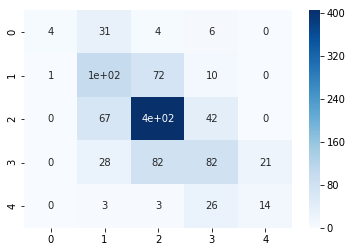

accuracy : 0.604
precisions : [0.8        0.43668122 0.71504425 0.4939759  0.4       ]
recalls : [0.08888889 0.54644809 0.78752437 0.38497653 0.30434783]
class no : 0


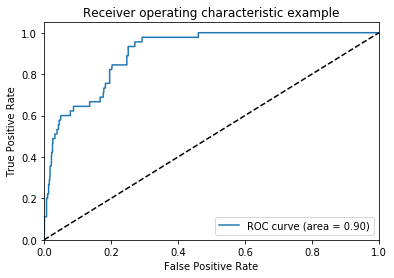

class no : 1


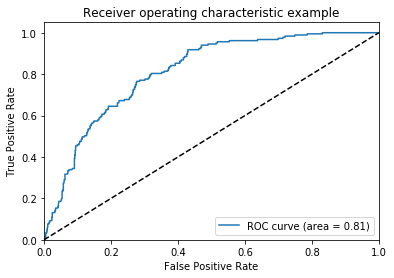

class no : 2


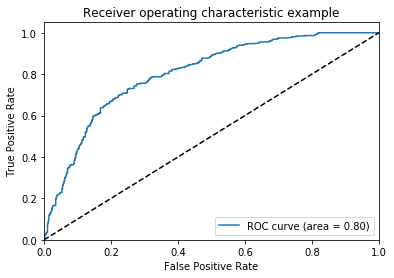

class no : 3


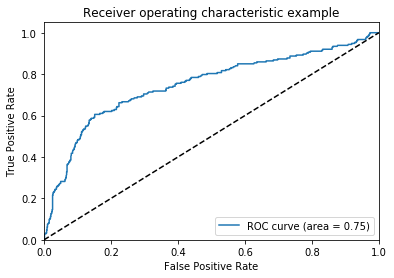

class no : 4


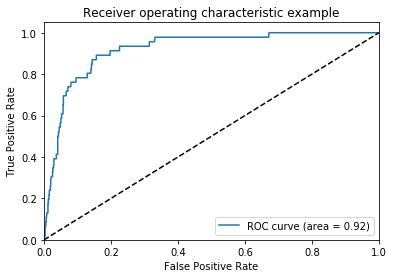

In [23]:
# Prediction
y_score = results[0].predict(X[-val:])
y_pred = np.argmax(y_score , axis = 1)

# True values
y_test = train_reviews.Sentiment.values[-val:]

# Confusion matrix
hmap = confusion_matrix(y_test , y_pred)
sns.heatmap(hmap , cmap = 'Blues' , annot = True)
plt.show()

# Metrics :
print('accuracy :' , accuracy_score(y_test , y_pred))
print('precisions :' , precision_score(y_test , y_pred , average = None))
print('recalls :' , recall_score(y_test , y_pred , average = None))

# ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i] , pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for each class (Sentiment label)
for i in range(n_classes):
    print('class no :' , i )
    
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Using area under ROC curve (AUC) as a measure of quality of the classification model:
AUC for Sentiment 0 = 90%
AUC for Sentiment 1 = 81%
AUC for Sentiment 2 = 80%
AUC for Sentiment 3 = 75%
AUC for Sentiment 4 = 92%

A high AUC, close to 1, means that the model has high classification accuracy.  Best quality of classification for Sentiments based on applying the LSTM model above is for Sentiments 0 ("negative") and 4 ("positive"), however the model performed poorly on the somewhat positive, somewhat negative, and neutral reviews. Those reviews in the latter 3 classes contain both positive and negative words at the same time, which may confound the network. 
